# Get data from the CERN Open Data repository

Download the data from CERN Open Data, compute some missing variables (momentum $p$ and $\theta$) and split the ouptut in multiple files, each file containing a bin of momentum.

The binning scheme and the output file name can be provided as an environmental variable, but we provide a default value to 
develop and debug the notebook.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import re 

# Here we load the OUTPUT environmental variable (that we'll set in the Snakefile) or, if not defined, we supply a default value.
output = os.environ.get("OUTPUT", "scratch/psi_10-30.pkl")
output

'scratch/psi_10-30.pkl'

We download a sample of Dimuon candidates collected by CMS in 2011 from the [OpenData portal](https://opendata.cern.ch/record/5201).
Then we perform some basic check to ensure everything went ok in the download and in the conversion from CSV.
For example, we list the columns...

In [2]:
df = pd.read_csv("https://opendata.cern.ch/record/5201/files/Dimuon_DoubleMu.csv")
df.columns

Index(['Run', 'Event', 'type1', 'E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1',
       'phi1', 'Q1', 'type2', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2',
       'Q2', 'M'],
      dtype='object')

## Selecting the data 
The analysis we wish to perform concerns narrow charmonium candidates which have masses of about 3-4 GeV. 
The dataset we obtained from the OpenData portal contains instead a much wider mass spectrum. We apply a preselection.

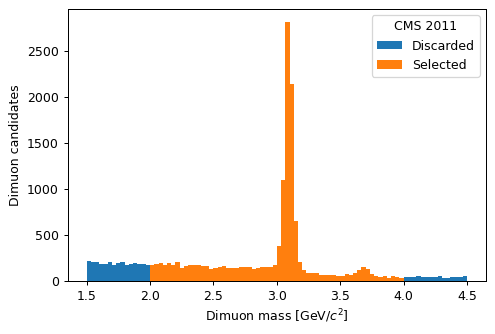

In [3]:
plt.figure(dpi=90)
plt.hist(df.M, bins=np.linspace(1.5,4.5,91), label="Discarded")
selected = df.query("M > 2 and M < 4").copy()
plt.hist(selected.M, bins=np.linspace(1.5,4.5,91), label="Selected")
plt.xlabel("Dimuon mass [GeV/$c^2$]")
plt.ylabel("Dimuon candidates")
plt.legend(title="CMS 2011")
plt.show()

## Adding new variables
The dataset does not include the momentum of the charmonium particles, but the momentum of the two muon is provided and it is sufficient to compute the dimuon momentum on our own.
Similarly, we can compute the azimuthal angle $\theta$ of the dimuon.

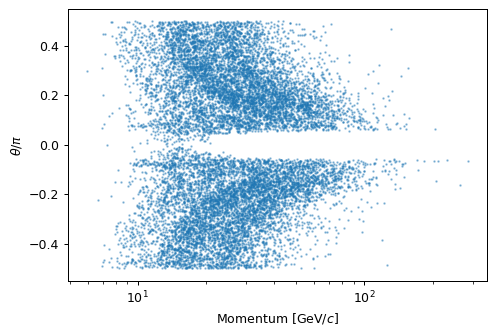

In [4]:
plt.figure(dpi=90)
selected['P'] = np.sqrt( (selected.px1 + selected.px2)**2 + (selected.py1 + selected.py2)**2 + (selected.pz1 + selected.pz2)**2 )
selected['PT'] = np.sqrt( (selected.px1 + selected.px2)**2 + (selected.py1 + selected.py2)**2 )
selected['THETA'] = np.arctan(np.sqrt( (selected.px1 + selected.px2)**2 + (selected.py1 + selected.py2)**2) / (selected.pz1 + selected.pz2) )
plt.scatter(selected.P, selected.THETA/np.pi, s=1, alpha=0.4)
plt.xscale('log')
plt.xlabel("Momentum [GeV/$c$]")
plt.ylabel("$\\theta / \\pi$")
plt.show()

## Splitting the dataset
We divide the dataset in bins of momentum and store each bin in a different pickle file.
The momentum boundaries defining the binning scheme are obtained processing the output file names.
In this way, the binning scheme is defined only once, in the `Snakefile`.

Note that if more than one output file name is passed through bash as an enviornment variable, 
then they will be separated by a blank. We divide the string into a list of string, by splitting on blanks.

The regular expression used to extract the boundaries means:
 * `.*_` any set of characters, of arbitrary length, is followed by `_`
 * `([0-9\.]*)` by a set of characters that only include digits and points,
 * `-` a dash,
 * `([0-9\.]*)` another set of characters including digits and points,
 * `\.pkl` and, finally, by `.pkl` (the escape is used to specify that `.` is a character and not a wildcard)

The parentheses used around the `[0-9\.]*` groups are used to identify those as the target of the search.
Indeed, `p_low` and `p_high` are the strings obtained by matching the pattern described above with filename. 
In principle, more than one occurrence could be found. We are selecting the first pair of boundaries with the `[0]` at the end of the line.

Finally, we choose the variables we want to store, here
 * `PT`
 * `THETA`
 * `M`,
 
we apply a selection based on the boundaries obtained from the regular expression, and we 
store the selected data to the output file.


In [5]:
for filename in output.split(' '):
    p_low, p_high = re.findall(r".*_([0-9\.]*)-([0-9\.]*)\.pkl", filename)[0]

    selected[['PT', 'THETA', 'M']].query(f"PT > {p_low} and PT <= {p_high}").to_pickle(filename)